Peakpower 30KWp and Losses of 15%

In [30]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# The next line is to make the plots appear in the notebook
%matplotlib inline 

### Getting data using PVLIB

In [31]:

#input parameters for retriving weather data hourly base

coordinates = [
    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),
]

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude,
                                          map_variables=True)
    pvlib_weather = weather[0]

print("Lenght of the Dataframe", pvlib_weather.shape[0])
print(pvlib_weather.head())


Lenght of the Dataframe 8760
                           temp_air  relative_humidity  ghi  dni  dhi   IR(h)  \
time(UTC)                                                                       
2016-01-01 00:00:00+00:00      2.76              86.92  0.0  0.0  0.0  273.70   
2016-01-01 01:00:00+00:00      2.04              88.54  0.0  0.0  0.0  274.88   
2016-01-01 02:00:00+00:00      1.32              90.16  0.0  0.0  0.0  276.05   
2016-01-01 03:00:00+00:00      0.60              91.78  0.0  0.0  0.0  277.23   
2016-01-01 04:00:00+00:00     -0.11              93.40  0.0  0.0  0.0  278.41   

                           wind_speed  wind_direction  pressure  
time(UTC)                                                        
2016-01-01 00:00:00+00:00        4.21           227.0  102055.0  
2016-01-01 01:00:00+00:00        3.75           231.0  102065.0  
2016-01-01 02:00:00+00:00        3.29           234.0  102075.0  
2016-01-01 03:00:00+00:00        2.83           238.0  102065.0  
2016-01

In [32]:
#pvlib_weather.head()

Trying to obtain data for energy production

In [33]:

#retriving data for Solar Position
tmys = []
pv_tilt = 35.0
solposdf = pd.DataFrame()
coordinates = [
    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),
]

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

#creating a dict with the input parameters
system = {'module': module, 
          'inverter': inverter,
          'surface_azimuth': 0}

# Making the call to retrive data

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude,
                                          map_variables=True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = pv_tilt
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude)
    )
    solposdf = solpos
    
print("Lenght of the Dataframe", solposdf.shape[0])
print(solposdf.head()) 


Lenght of the Dataframe 8760
                           apparent_zenith      zenith  apparent_elevation  \
utc_time                                                                     
2016-01-01 00:00:00+00:00       149.016740  149.016740          -59.016740   
2016-01-01 01:00:00+00:00       143.802773  143.802773          -53.802773   
2016-01-01 02:00:00+00:00       136.291171  136.291171          -46.291171   
2016-01-01 03:00:00+00:00       127.637063  127.637063          -37.637063   
2016-01-01 04:00:00+00:00       118.555923  118.555923          -28.555923   

                           elevation    azimuth  equation_of_time  
utc_time                                                           
2016-01-01 00:00:00+00:00 -59.016740  23.007008         -3.070237  
2016-01-01 01:00:00+00:00 -53.802773  46.256946         -3.090043  
2016-01-01 02:00:00+00:00 -46.291171  64.380845         -3.109842  
2016-01-01 03:00:00+00:00 -37.637063  78.887059         -3.129633  
2016-01-01 04:00

In [34]:

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude,
    map_variables=True,
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
       
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)


## Converting all variables to a DataFrame

In [35]:

dni_extra = dni_extra.to_frame(name="dni_PVlib")
dni_extra.head(2)


,dni_PVlib
utc_time,
2016-01-01 00:00:00+00:00,1413.981805
2016-01-01 01:00:00+00:00,1413.981805


In [36]:

airmass = airmass.to_frame(name="airmass")
airmass.head(2)


,airmass
utc_time,
2016-01-01 00:00:00+00:00,NaN
2016-01-01 01:00:00+00:00,NaN


In [37]:
#pressure 

In [38]:

am_abs = am_abs.to_frame(name="am_abs")
am_abs.head(2)


,am_abs
utc_time,
2016-01-01 00:00:00+00:00,NaN
2016-01-01 01:00:00+00:00,NaN


In [39]:

aoi = aoi.to_frame(name="aoi")
aoi.head(2)


,aoi
utc_time,
2016-01-01 00:00:00+00:00,98.394005
2016-01-01 01:00:00+00:00,99.631542


In [40]:
#total_irradiance

In [41]:

cell_temperature = cell_temperature.to_frame(name="cell_temperature")
cell_temperature.head(2)


,cell_temperature
utc_time,
2016-01-01 00:00:00+00:00,2.76
2016-01-01 01:00:00+00:00,2.04


In [42]:

effective_irradiance = effective_irradiance.to_frame(name="effective_irradiance")
effective_irradiance.head(2)


,effective_irradiance
utc_time,
2016-01-01 00:00:00+00:00,0.0
2016-01-01 01:00:00+00:00,0.0


In [43]:

ac = ac.to_frame(name="ac_current")
ac.head(2)


,ac_current
utc_time,
2016-01-01 00:00:00+00:00,-0.075
2016-01-01 01:00:00+00:00,-0.075


In [44]:
#dc

## Joining all dataframes in one big dataframe

Checking for missing values

In [45]:

# Counting missing values 
print("Number of missing Values in am_abs variable",am_abs["am_abs"].isna().count())
print("Size of the am_abs dataframe", am_abs.shape[0] )
print("\n")
# Counting missing values 
print("Number of missing Values in airmass variable",airmass["airmass"].isna().count())
print("Size of the airmass dataframe", airmass.shape[0] )


Number of missing Values in am_abs variable 8760
Size of the am_abs dataframe 8760


Number of missing Values in airmass variable 8760
Size of the airmass dataframe 8760


These variables will not be used in the project since all it's variables are missing values

In [46]:

#joining everything.

pv_berlin = pvlib_weather.join([solposdf,aoi, 
                                total_irradiance, cell_temperature, 
                                effective_irradiance, ac, dc], how="left", sort =True)
    
pv_berlin.sort_values(by="time(UTC)").head()


,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,apparent_zenith,...,cell_temperature,effective_irradiance,ac_current,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
time(UTC),,,,,,,,,,,,,,,,,,,,,
2006-12-01 00:00:00+00:00,5.37,93.05,0.0,0.0,0.0,285.17,4.20,165.0,102801.0,146.817839,...,5.37,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 01:00:00+00:00,5.10,93.45,0.0,0.0,0.0,276.94,4.11,167.0,102702.0,141.050109,...,5.10,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 02:00:00+00:00,4.83,93.85,0.0,0.0,0.0,268.72,4.01,169.0,102602.0,133.276617,...,4.83,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 03:00:00+00:00,4.56,94.24,0.0,0.0,0.0,260.50,3.91,173.0,102562.0,124.520191,...,4.56,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 04:00:00+00:00,4.29,94.64,0.0,0.0,0.0,252.27,3.82,176.0,102522.0,115.424589,...,4.29,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#pv_berlin.sort_values(by="time(UTC)").tail()

In [48]:
#pv_berlin.describe()

### This way to obtain the power values the PVGIS will be used. The power values are going to be the variables that this ML model is trying to predict.   

In [49]:

import io
import json
from pathlib import Path
import requests
import pandas as pd
from pvlib.iotools import read_epw, parse_epw
import warnings
from pvlib._deprecation import pvlibDeprecationWarning
import datetime

URL = 'https://re.jrc.ec.europa.eu/api/v5_2/'
peakpowervar = 30

# Dictionary mapping PVGIS names to pvlib names
VARIABLE_MAP = {
    'G(h)': 'ghi',
    'Gb(n)': 'dni',
    'Gd(h)': 'dhi',
    'G(i)': 'poa_global',
    'Gb(i)': 'poa_direct',
    'Gd(i)': 'poa_sky_diffuse',
    'Gr(i)': 'poa_ground_diffuse',
    'H_sun': 'solar_elevation',
    'T2m': 'temp_air',
    'RH': 'relative_humidity',
    'SP': 'pressure',
    'WS10m': 'wind_speed',
    'WD10m': 'wind_direction',
}


def get_pvgis_hourly(latitude, longitude, start=None, end=None,
                     raddatabase=None, components=True,
                     surface_tilt=0, surface_azimuth=0,
                     outputformat='json',
                     usehorizon=True, userhorizon=None,
                     pvcalculation=False,
                     peakpower= peakpowervar, pvtechchoice='crystSi',
                     mountingplace='free', loss=0, trackingtype=0,
                     optimal_surface_tilt=False, optimalangles=False,
                     url=URL, map_variables=True, timeout=30):
    
    
    # noqa: E501
    # use requests to format the query string by passing params dictionary
    params = {'lat': latitude, 'lon': longitude, 'outputformat': outputformat,
              'angle': surface_tilt, 'aspect': surface_azimuth,
              'pvcalculation': int(pvcalculation),
              'pvtechchoice': pvtechchoice, 'mountingplace': mountingplace,
              'trackingtype': trackingtype, 'components': int(components),
              'usehorizon': int(usehorizon),
              'optimalangles': int(optimalangles),
              'optimalinclination': int(optimal_surface_tilt), 'loss': loss}
    # pvgis only takes 0 for False, and 1 for True, not strings
    if userhorizon is not None:
        params['userhorizon'] = ','.join(str(x) for x in userhorizon)
    if raddatabase is not None:
        params['raddatabase'] = raddatabase
    if start is not None:
        params['startyear'] = start if isinstance(start, int) else start.year
    if end is not None:
        params['endyear'] = end if isinstance(end, int) else end.year
    if peakpower is not None:
        params['peakpower'] = peakpower

    # The url endpoint for hourly radiation is 'seriescalc'
    res = requests.get(url + 'seriescalc', params=params, timeout=timeout)
    # PVGIS returns really well formatted error messages in JSON for HTTP/1.1
    # 400 BAD REQUEST so try to return that if possible, otherwise raise the
    # HTTP/1.1 error caught by requests
    if not res.ok:
        try:
            err_msg = res.json()
        except Exception:
            res.raise_for_status()
        else:
            raise requests.HTTPError(err_msg['message'])

    return read_pvgis_hourly(io.StringIO(res.text), pvgis_format=outputformat,
                             map_variables=map_variables)



def _parse_pvgis_hourly_json(src, map_variables):
    inputs = src['inputs']
    metadata = src['meta']
    data = pd.DataFrame(src['outputs']['hourly'])
    data.index = pd.to_datetime(data['time'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time', axis=1)
    data = data.astype(dtype={'Int': 'int'})  # The 'Int' column to be integer
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)
    return data, inputs, metadata


def _parse_pvgis_hourly_csv(src, map_variables):
    # The first 4 rows are latitude, longitude, elevation, radiation database
    inputs = {}
    # 'Latitude (decimal degrees): 45.000\r\n'
    inputs['latitude'] = float(src.readline().split(':')[1])
    # 'Longitude (decimal degrees): 8.000\r\n'
    inputs['longitude'] = float(src.readline().split(':')[1])
    # Elevation (m): 1389.0\r\n
    inputs['elevation'] = float(src.readline().split(':')[1])
    # 'Radiation database: \tPVGIS-SARAH\r\n'
    inputs['radiation_database'] = src.readline().split(':')[1].strip()
    # Parse through the remaining metadata section (the number of lines for
    # this section depends on the requested parameters)
    while True:
        line = src.readline()
        if line.startswith('time,'):  # The data header starts with 'time,'
            # The last line of the metadata section contains the column names
            names = line.strip().split(',')
            break
        # Only retrieve metadata from non-empty lines
        elif line.strip() != '':
            inputs[line.split(':')[0]] = line.split(':')[1].strip()
        elif line == '':  # If end of file is reached
            raise ValueError('No data section was detected. File has probably '
                             'been modified since being downloaded from PVGIS')
    # Save the entries from the data section to a list, until an empty line is
    # reached an empty line. The length of the section depends on the request
    data_lines = []
    while True:
        line = src.readline()
        if line.strip() == '':
            break
        else:
            data_lines.append(line.strip().split(','))
    data = pd.DataFrame(data_lines, columns=names)
    data.index = pd.to_datetime(data['time'], format='%Y%m%d:%H%M', utc=True)
    data = data.drop('time', axis=1)
    if map_variables:
        data = data.rename(columns=VARIABLE_MAP)
    # All columns should have the dtype=float, except 'Int' which should be
    # integer. It is necessary to convert to float, before converting to int
    data = data.astype(float).astype(dtype={'Int': 'int'})
    # Generate metadata dictionary containing description of parameters
    metadata = {}
    for line in src.readlines():
        if ':' in line:
            metadata[line.split(':')[0]] = line.split(':')[1].strip()
    return data, inputs, metadata


def read_pvgis_hourly(filename, pvgis_format=None, map_variables=True):
   
    # get the PVGIS outputformat
    if pvgis_format is None:
        # get the file extension from suffix, but remove the dot and make sure
        # it's lower case to compare with csv, or json
        # NOTE: basic format is not supported for PVGIS Hourly as the data
        # format does not include a header
        # NOTE: raises TypeError if filename is a buffer
        outputformat = Path(filename).suffix[1:].lower()
    else:
        outputformat = pvgis_format

    # parse the pvgis file based on the output format, either 'json' or 'csv'
    # NOTE: json and csv output formats have parsers defined as private
    # functions in this module

    # JSON: use Python built-in json module to convert file contents to a
    # Python dictionary, and pass the dictionary to the
    # _parse_pvgis_hourly_json() function from this module
    if outputformat == 'json':
        try:
            src = json.load(filename)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                src = json.load(fbuf)
        return _parse_pvgis_hourly_json(src, map_variables=map_variables)

    # CSV: use _parse_pvgis_hourly_csv()
    if outputformat == 'csv':
        try:
            pvgis_data = _parse_pvgis_hourly_csv(
                filename, map_variables=map_variables)
        except AttributeError:  # str/path has no .read() attribute
            with open(str(filename), 'r') as fbuf:
                pvgis_data = _parse_pvgis_hourly_csv(
                    fbuf, map_variables=map_variables)
        return pvgis_data

    # raise exception if pvgis format isn't in ['csv', 'json']
    err_msg = (
        "pvgis format '{:s}' was unknown, must be either 'json' or 'csv'")\
        .format(outputformat)
    raise ValueError(err_msg)


In [50]:

#Defining the inputs
lat = 52.5 
lon = 13.4
start=pd.Timestamp('2006-12-01')
end=pd.Timestamp('2016-01-31')
raddatabase='PVGIS-SARAH2'
loss=15

data = get_pvgis_hourly(latitude = lat, 
                    longitude = lon, 
                    start=start, 
                    end=end,
                    raddatabase=raddatabase,
                    components=True, #Maybe need to change for 1
                    surface_tilt = pv_tilt, #this var comes from getting solar position part
                    surface_azimuth=0, # 0=south For Noth Hemisphere
                    outputformat='csv',
                    usehorizon=True, #Include effects of horizon
                    userhorizon=None, #Optional user specified elevation of horizon in degrees - Will not use it 
                    pvcalculation=True,
                    peakpower= peakpowervar, # Source: https://www.berlin.de/umweltatlas/en/energy/solar-systems/continually-updated/map-description/ 
                    pvtechchoice='crystSi',
                    mountingplace='free',  #Type of mounting for PV system. Options of 'free' for free-standing 
                                           #and 'building' for building-integrated.
                    loss= loss, #considering a global loss of 30% section 11.2.2 Source: https://www.ise.fraunhofer.de/content/dam/ise/en/documents/publications/studies/recent-facts-about-photovoltaics-in-germany.pdf 
                    trackingtype=0, #Type of mounting 0=fixed
                    optimal_surface_tilt=True, #Calculate the optimum tilt angle.
                    optimalangles=False, #Calculate the optimum tilt and azimuth angles.                      
                    url=URL, 
                    map_variables=True, # When true, renames columns of the Dataframe to pvlib variable names
                    timeout=30) # Time in seconds to wait for server response before timeout
PVgis_data = data[0]


In [51]:
#PVgis_data.head()

In [52]:
pv_berlin.sort_values(by="time(UTC)")

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,apparent_zenith,...,cell_temperature,effective_irradiance,ac_current,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
time(UTC),,,,,,,,,,,,,,,,,,,,,
2006-12-01 00:00:00+00:00,5.37,93.05,0.0,0.0,0.0,285.17,4.20,165.0,102801.0,146.817839,...,5.37,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 01:00:00+00:00,5.10,93.45,0.0,0.0,0.0,276.94,4.11,167.0,102702.0,141.050109,...,5.10,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 02:00:00+00:00,4.83,93.85,0.0,0.0,0.0,268.72,4.01,169.0,102602.0,133.276617,...,4.83,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 03:00:00+00:00,4.56,94.24,0.0,0.0,0.0,260.50,3.91,173.0,102562.0,124.520191,...,4.56,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-01 04:00:00+00:00,4.29,94.64,0.0,0.0,0.0,252.27,3.82,176.0,102522.0,115.424589,...,4.29,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-31 19:00:00+00:00,3.26,80.72,0.0,0.0,0.0,282.11,5.87,243.0,100200.0,118.880407,...,3.26,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-31 20:00:00+00:00,2.67,81.41,0.0,0.0,0.0,278.22,5.60,242.0,100184.0,127.638186,...,2.67,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-31 21:00:00+00:00,2.09,82.10,0.0,0.0,0.0,274.33,5.34,246.0,100184.0,135.471702,...,2.09,0.0,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## The idea is to make the mean of a hourly measure to create a var to join the 2 df

In [53]:

pvgis_temp = (
PVgis_data
    .reset_index()
    .assign(
        date = lambda x: x["time"].dt.date,
        m = lambda x: x["time"].dt.hour,
        ymdh = lambda x: x["date"].astype(str) + " " + x["m"].astype(str)
    )
)
pvgis_temp.head()


,time,P,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,date,m,ymdh
0,2006-01-01 00:11:00+00:00,0.0,0.0,0.0,0.0,0.0,3.30,4.07,0,2006-01-01,0,2006-01-01 0
1,2006-01-01 01:11:00+00:00,0.0,0.0,0.0,0.0,0.0,3.18,3.93,0,2006-01-01,1,2006-01-01 1
2,2006-01-01 02:11:00+00:00,0.0,0.0,0.0,0.0,0.0,3.16,3.72,0,2006-01-01,2,2006-01-01 2
3,2006-01-01 03:11:00+00:00,0.0,0.0,0.0,0.0,0.0,2.92,3.45,0,2006-01-01,3,2006-01-01 3
4,2006-01-01 04:11:00+00:00,0.0,0.0,0.0,0.0,0.0,2.65,3.24,0,2006-01-01,4,2006-01-01 4


In [54]:

pv_berlintemp = (
pv_berlin
    .reset_index()
    .assign(
        date = lambda x: x["time(UTC)"].dt.date,
        m = lambda x: x["time(UTC)"].dt.hour,
        ymdh = lambda x: x["date"].astype(str) + " " + x["m"].astype(str)
            )

)
pv_final = pd.merge(pv_berlintemp,pvgis_temp[["ymdh","P"]], on="ymdh", how="left")
pv_final.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   time(UTC)             8760 non-null   datetime64[ns, UTC]
 1   temp_air              8760 non-null   float64            
 2   relative_humidity     8760 non-null   float64            
 3   ghi                   8760 non-null   float64            
 4   dni                   8760 non-null   float64            
 5   dhi                   8760 non-null   float64            
 6   IR(h)                 8760 non-null   float64            
 7   wind_speed            8760 non-null   float64            
 8   wind_direction        8760 non-null   float64            
 9   pressure              8760 non-null   float64            
 10  apparent_zenith       8760 non-null   float64            
 11  zenith                8760 non-null   float64            
 12  appare

In [55]:
#pv_final.head()

In [56]:

#there are some temporary columns that need to be removed from the dataframe, they are "date", "m","ymdh" 
pv_final.drop(columns=["date", "m","ymdh"], inplace=True)
pv_final.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   time(UTC)             8760 non-null   datetime64[ns, UTC]
 1   temp_air              8760 non-null   float64            
 2   relative_humidity     8760 non-null   float64            
 3   ghi                   8760 non-null   float64            
 4   dni                   8760 non-null   float64            
 5   dhi                   8760 non-null   float64            
 6   IR(h)                 8760 non-null   float64            
 7   wind_speed            8760 non-null   float64            
 8   wind_direction        8760 non-null   float64            
 9   pressure              8760 non-null   float64            
 10  apparent_zenith       8760 non-null   float64            
 11  zenith                8760 non-null   float64            
 12  appare

In [57]:

#creating a  meteorological season variable
pv_final.reset_index()
pv_final['season'] = pv_final["time(UTC)"].dt.month%12 // 3 + 1
pv_final.head(3)


,time(UTC),temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,...,ac_current,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx,P,season
0,2016-01-01 00:00:00+00:00,2.76,86.92,0.0,0.0,0.0,273.70,4.21,227.0,102055.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2016-01-01 01:00:00+00:00,2.04,88.54,0.0,0.0,0.0,274.88,3.75,231.0,102065.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2016-01-01 02:00:00+00:00,1.32,90.16,0.0,0.0,0.0,276.05,3.29,234.0,102075.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Exploring the dataset

In [58]:
#saving the dataframe and importing it
pv_final.to_csv("./pv_final.csv",index=False)
pv_final = pd.read_csv("pv_final.csv")
pv_final['time(UTC)'] = pd.to_datetime(pv_final['time(UTC)'])
# Checking for Missing Values and type of values of the columns.

In [59]:
pv_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   time(UTC)             8760 non-null   datetime64[ns, UTC]
 1   temp_air              8760 non-null   float64            
 2   relative_humidity     8760 non-null   float64            
 3   ghi                   8760 non-null   float64            
 4   dni                   8760 non-null   float64            
 5   dhi                   8760 non-null   float64            
 6   IR(h)                 8760 non-null   float64            
 7   wind_speed            8760 non-null   float64            
 8   wind_direction        8760 non-null   float64            
 9   pressure              8760 non-null   float64            
 10  apparent_zenith       8760 non-null   float64            
 11  zenith                8760 non-null   float64            
 12  appare

In [60]:
pv_final.rename(columns={"P":"Power(Wh)"}, inplace=True)
pv_final.head()

,time(UTC),temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,...,ac_current,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx,Power(Wh),season
0,2016-01-01 00:00:00+00:00,2.76,86.92,0.0,0.0,0.0,273.70,4.21,227.0,102055.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2016-01-01 01:00:00+00:00,2.04,88.54,0.0,0.0,0.0,274.88,3.75,231.0,102065.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2016-01-01 02:00:00+00:00,1.32,90.16,0.0,0.0,0.0,276.05,3.29,234.0,102075.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2016-01-01 03:00:00+00:00,0.60,91.78,0.0,0.0,0.0,277.23,2.83,238.0,102065.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2016-01-01 04:00:00+00:00,-0.11,93.40,0.0,0.0,0.0,278.41,2.38,242.0,102055.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [61]:
pv_final.describe(include= "all").round(2)

C:\Users\icaro\AppData\Local\Temp\ipykernel_4476\2817904779.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pv_final.describe(include= "all").round(2)


,time(UTC),temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,...,ac_current,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx,Power(Wh),season
count,8760,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,...,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00
unique,8760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2006-12-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-01-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,10.35,75.92,126.12,119.64,64.37,304.23,3.65,216.23,101059.96,...,10.53,0.29,0.27,24.72,19.71,11.74,0.29,0.21,3527.22,2.50
std,NaN,7.74,16.03,206.05,231.06,96.48,42.73,1.85,85.17,922.30,...,16.60,0.44,0.39,26.41,21.31,17.66,0.42,0.30,5998.51,1.11
min,NaN,-10.03,29.21,0.00,0.00,0.00,169.15,0.15,0.00,98193.00,...,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,NaN,4.52,64.98,0.00,0.00,0.00,271.78,2.29,163.00,100466.00,...,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00


## Plotting some graphs 

In [62]:
import numpy as np
import seaborn as sns 
sns.set() 

In [63]:
pv_final.columns

Index(['time(UTC)', 'temp_air', 'relative_humidity', 'ghi', 'dni', 'dhi',
       'IR(h)', 'wind_speed', 'wind_direction', 'pressure', 'apparent_zenith',
       'zenith', 'apparent_elevation', 'elevation', 'azimuth',
       'equation_of_time', 'aoi', 'poa_global', 'poa_direct', 'poa_diffuse',
       'poa_sky_diffuse', 'poa_ground_diffuse', 'cell_temperature',
       'effective_irradiance', 'ac_current', 'i_sc', 'i_mp', 'v_oc', 'v_mp',
       'p_mp', 'i_x', 'i_xx', 'Power(Wh)', 'season'],
      dtype='object')

## Automatizing the plotting

In [64]:
import matplotlib.pyplot as plt
'''
column_plot =['temp_air', 'relative_humidity', 'ghi', 'dni', 'dhi',
       'IR(h)', 'wind_speed', 'wind_direction', 'pressure', 'apparent_zenith',
       'zenith', 'apparent_elevation', 'elevation', 'azimuth',
       'equation_of_time', 'dni_PVlib', 'aoi', 'poa_global', 'poa_direct',
       'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse',
       'cell_temperature', 'effective_irradiance', 'ac_current', 'i_sc',
       'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx', "Power(Wh)"]

for column in column_plot:
    plt.figure()
    plt.figure(figsize = (16,8))
    ax = sns.histplot(data=pv_final[pv_final[column] != 0], x=column, kde=True, bins= 100) #Ignoring the values that are equal to 0
    splitcolumn = column.split("_")
    title = ""
    for name in splitcolumn:
        x_title = name.title()
        title += x_title + " " 
    ax.set_title(title + " Values", fontsize=18)
    title = ""
        
    ax = ax
    plt.show
'''

'\ncolumn_plot =[\'temp_air\', \'relative_humidity\', \'ghi\', \'dni\', \'dhi\',\n       \'IR(h)\', \'wind_speed\', \'wind_direction\', \'pressure\', \'apparent_zenith\',\n       \'zenith\', \'apparent_elevation\', \'elevation\', \'azimuth\',\n       \'equation_of_time\', \'dni_PVlib\', \'aoi\', \'poa_global\', \'poa_direct\',\n       \'poa_diffuse\', \'poa_sky_diffuse\', \'poa_ground_diffuse\',\n       \'cell_temperature\', \'effective_irradiance\', \'ac_current\', \'i_sc\',\n       \'i_mp\', \'v_oc\', \'v_mp\', \'p_mp\', \'i_x\', \'i_xx\', "Power(Wh)"]\n\nfor column in column_plot:\n    plt.figure()\n    plt.figure(figsize = (16,8))\n    ax = sns.histplot(data=pv_final[pv_final[column] != 0], x=column, kde=True, bins= 100) #Ignoring the values that are equal to 0\n    splitcolumn = column.split("_")\n    title = ""\n    for name in splitcolumn:\n        x_title = name.title()\n        title += x_title + " " \n    ax.set_title(title + " Values", fontsize=18)\n    title = ""\n        \

## Correlation

In [65]:
# Defining the function to plot the correlation
def corr_graph(df):
    plt.figure(figsize=(30,15))
    mask = np.triu(np.ones_like(df.corr(), dtype=bool)) 
    heatmap = sns.heatmap(df.corr(),mask=mask, vmin=-1, vmax=1, annot=True, cmap="BrBG", fmt='.2f')
    heatmap.set_title("Correlation", fontdict={"fontsize":18}, pad=16)
    plt.show
    return(heatmap)

In [66]:
#pip install ipython

<AxesSubplot:title={'center':'Correlation'}>

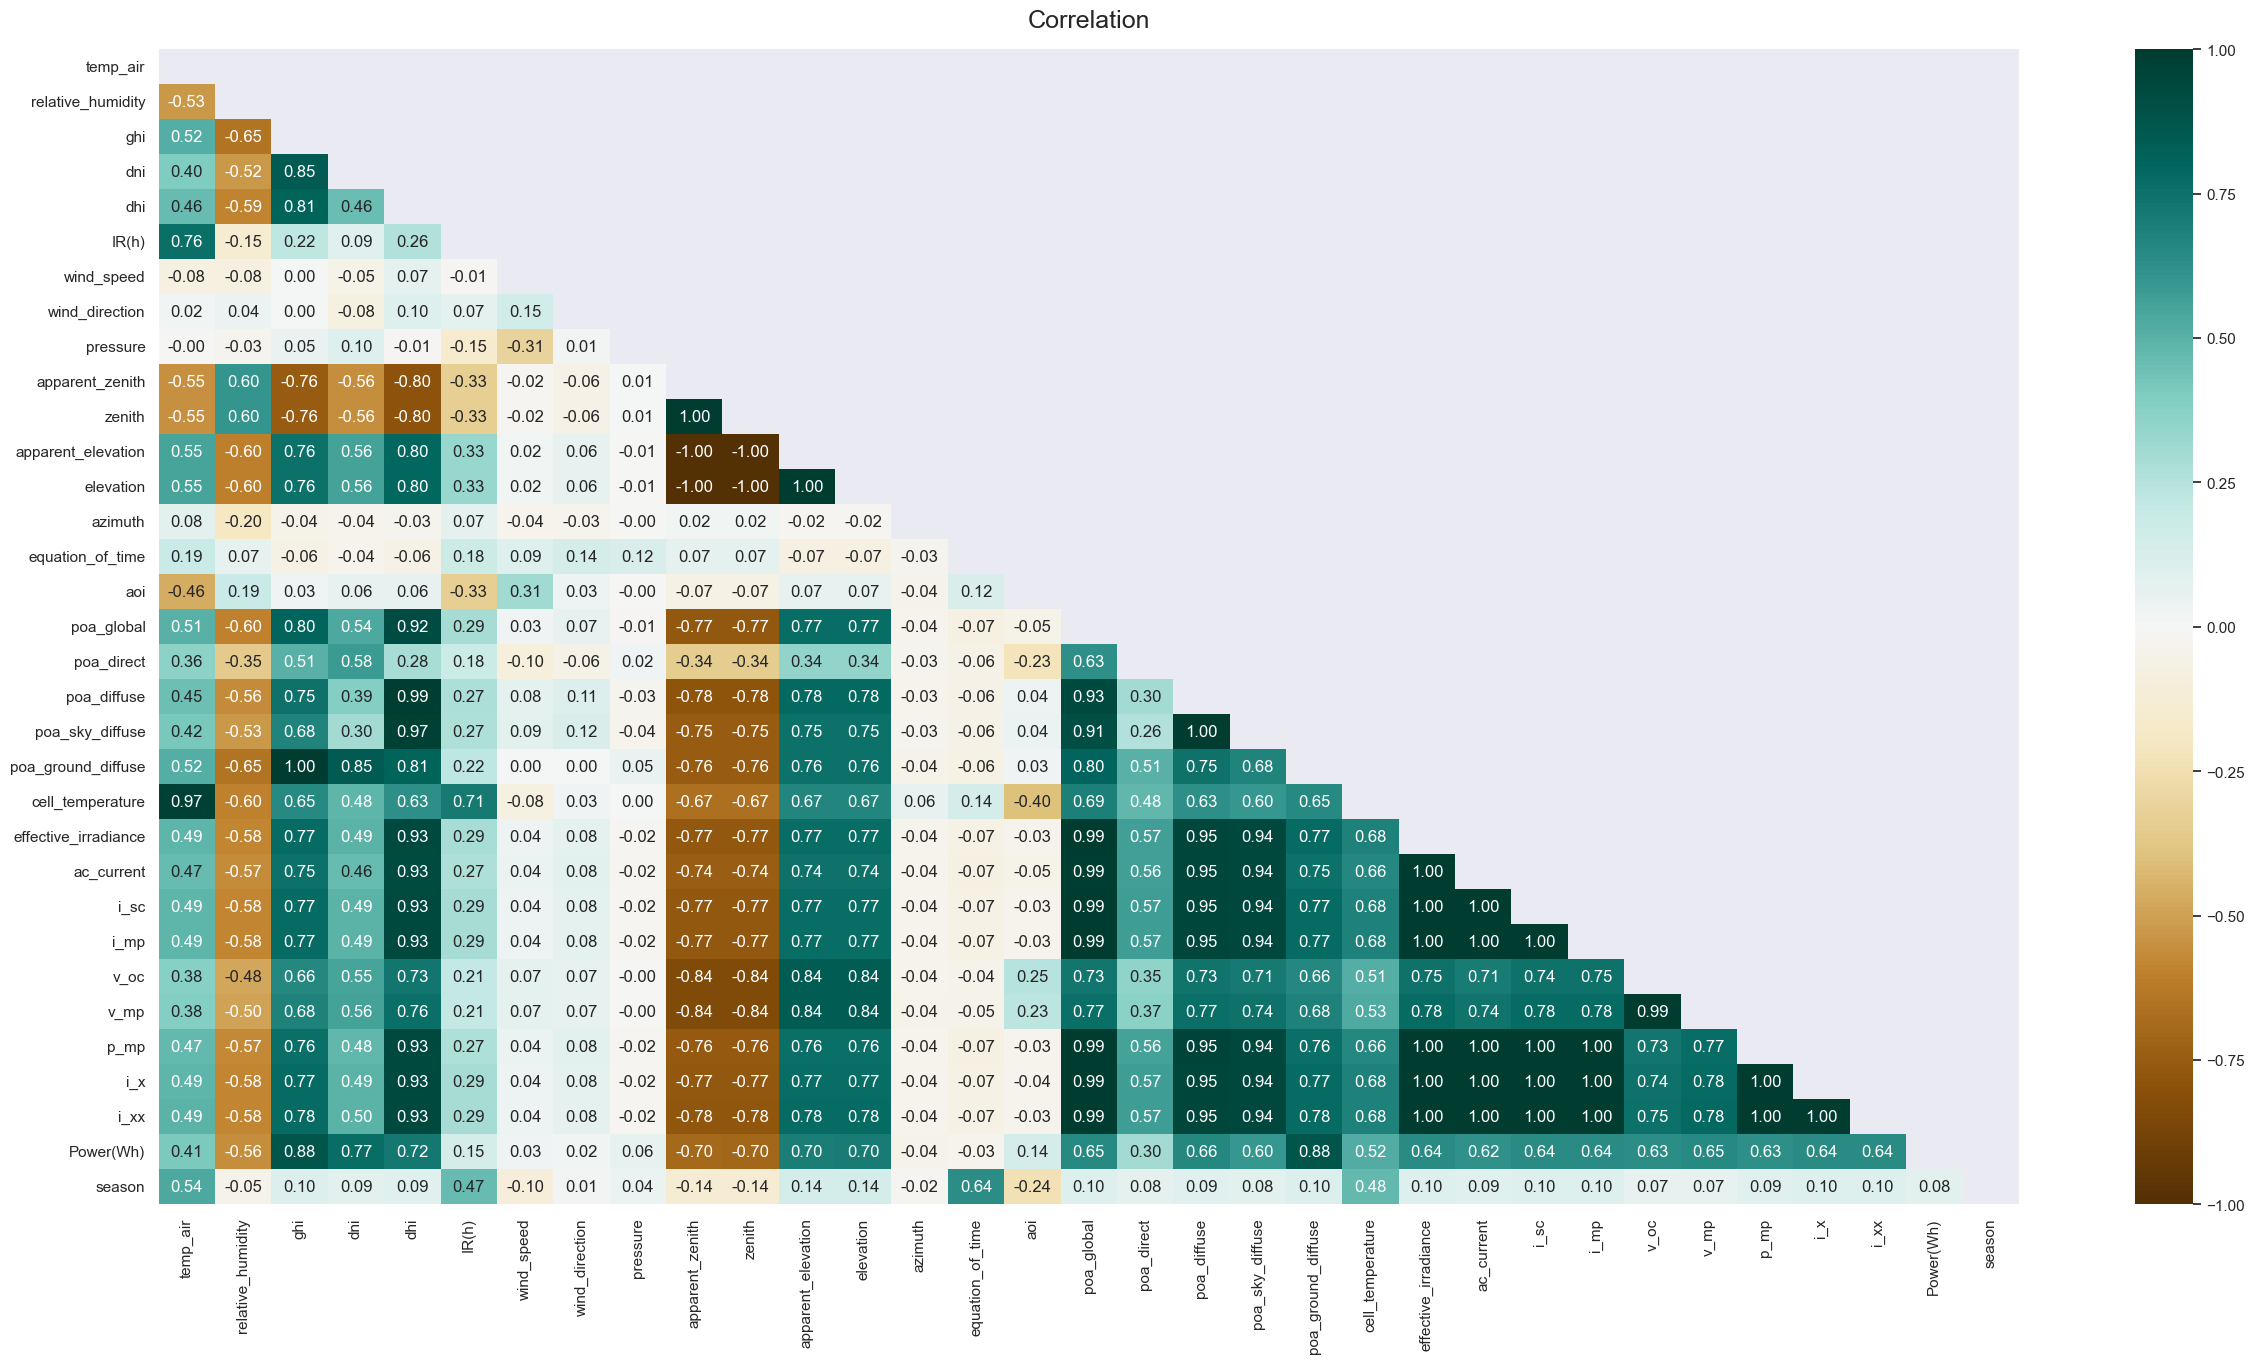

In [67]:
#calling the function
# wx, gtk, osx, tk, empty uses default
%matplotlib inline
corr_graph(pv_final)

Observing the correlation, a great part of the predictors variables have a high correlation between each other. These variables will be further analysed by other techniques and removed if necessary. 

# Making the first Interaction with ML

### The Power(KWh) column Power(KWh) is the variable to be predicted.

Need to create some features using datetime, for example day, weekday, month and year. And then remove the variable daytime from the Dataframe, because when I do the model trining the hot encoder works on the datetime and messes up with my results.  

In [68]:
pv_final.head(2)

,time(UTC),temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,...,ac_current,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx,Power(Wh),season
0,2016-01-01 00:00:00+00:00,2.76,86.92,0.0,0.0,0.0,273.70,4.21,227.0,102055.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2016-01-01 01:00:00+00:00,2.04,88.54,0.0,0.0,0.0,274.88,3.75,231.0,102065.0,...,-0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [69]:
# creating the day variable
pv_final['day'] = pv_final["time(UTC)"].dt.day
pv_final['weekday'] = pv_final["time(UTC)"].dt.weekday
pv_final['weekday_name'] = pv_final["time(UTC)"].dt.day_name()
pv_final['month'] =pv_final["time(UTC)"].dt.month
pv_final['month_name'] =pv_final["time(UTC)"].dt.month_name()
pv_final['year'] =pv_final["time(UTC)"].dt.year
pv_final.head(2)

,time(UTC),temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,...,i_x,i_xx,Power(Wh),season,day,weekday,weekday_name,month,month_name,year
0,2016-01-01 00:00:00+00:00,2.76,86.92,0.0,0.0,0.0,273.70,4.21,227.0,102055.0,...,0.0,0.0,0.0,1,1,4,Friday,1,January,2016
1,2016-01-01 01:00:00+00:00,2.04,88.54,0.0,0.0,0.0,274.88,3.75,231.0,102065.0,...,0.0,0.0,0.0,1,1,4,Friday,1,January,2016


In [70]:
# Now dropping the time(UTC) column
pv_final.drop(columns=["time(UTC)"], inplace=True)
#pv_final.drop(columns=["time(UTC)"])
pv_final.head(2)

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,apparent_zenith,...,i_x,i_xx,Power(Wh),season,day,weekday,weekday_name,month,month_name,year
0,2.76,86.92,0.0,0.0,0.0,273.70,4.21,227.0,102055.0,149.016740,...,0.0,0.0,0.0,1,1,4,Friday,1,January,2016
1,2.04,88.54,0.0,0.0,0.0,274.88,3.75,231.0,102065.0,143.802773,...,0.0,0.0,0.0,1,1,4,Friday,1,January,2016


### Training the model 

In [71]:
# Removing the values = 0
pv_final_cleaned = pv_final.loc[~(pv_final["Power(Wh)"]==0)]
(pv_final_cleaned == 0).all()

temp_air                False
relative_humidity       False
ghi                     False
dni                     False
dhi                     False
IR(h)                   False
wind_speed              False
wind_direction          False
pressure                False
apparent_zenith         False
zenith                  False
apparent_elevation      False
elevation               False
azimuth                 False
equation_of_time        False
aoi                     False
poa_global              False
poa_direct              False
poa_diffuse             False
poa_sky_diffuse         False
poa_ground_diffuse      False
cell_temperature        False
effective_irradiance    False
ac_current              False
i_sc                    False
i_mp                    False
v_oc                    False
v_mp                    False
p_mp                    False
i_x                     False
i_xx                    False
Power(Wh)               False
season                  False
day       

In [72]:
pv_final_cleaned.shape

(4123, 39)

In [73]:
pv_final_cleaned.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure,apparent_zenith,...,i_x,i_xx,Power(Wh),season,day,weekday,weekday_name,month,month_name,year
8,-0.20,94.53,30.0,170.05,15.0,268.15,1.66,251.0,102144.0,85.862670,...,0.054036,0.040079,2552.4,1,1,4,Friday,1,January,2016
9,0.99,93.21,54.0,152.85,27.0,265.10,1.67,254.0,102134.0,80.546226,...,0.112267,0.083135,1860.0,1,1,4,Friday,1,January,2016
10,2.17,91.90,18.0,38.81,9.0,262.05,1.69,258.0,102124.0,76.971560,...,0.040401,0.029978,2749.8,1,1,4,Friday,1,January,2016
11,3.35,90.58,14.0,27.98,7.0,259.00,1.71,261.0,102114.0,75.490287,...,0.031615,0.023465,1809.6,1,1,4,Friday,1,January,2016
12,2.55,92.96,10.0,21.71,5.0,254.28,1.52,264.0,102128.0,76.247190,...,0.022682,0.016839,1473.6,1,1,4,Friday,1,January,2016


In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

y=  pv_final_cleaned["Power(Wh)"]
X = pv_final_cleaned
X = pv_final_cleaned.drop(columns="Power(Wh)")

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1990)

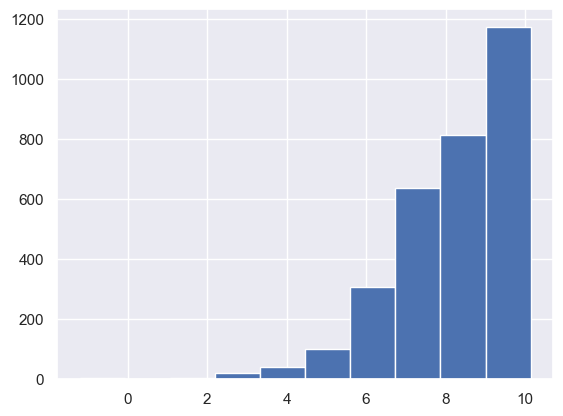

In [75]:
# y_train.describe()
plt.hist(np.log(y_train).replace([np.inf, -np.inf], 0))
plt.show()

In [76]:
'''
from sklearn.linear_model import LinearRegression
from sklearn import metrics 

# defining the score printing function for TRAIN data
def linear_train_score(X_train, y_train):
    score = search.score(X_train, y_train)
    return print("Linear Train R² score = {}".format(score.round(3)))
'''

'\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn import metrics \n\n# defining the score printing function for TRAIN data\ndef linear_train_score(X_train, y_train):\n    score = search.score(X_train, y_train)\n    return print("Linear Train R² score = {}".format(score.round(3)))\n'

## Training the model

In [77]:
'''
# import
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

# select categorical and numerical column names
X_cat_columns = X_train.select_dtypes(include="object").columns
X_num_columns = X_train.select_dtypes(exclude="object").columns


#Setting the imputers, Scaler 
imputer = KNNImputer()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MinMaxScaler(feature_range=(0, 10))
#ang_imputer = KNNImputer()
#ang_scaler = Normalizer()

# create numerical pipeline
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     
# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns)        
    ]
)

from sklearn.model_selection import RandomizedSearchCV
full_pipeline = make_pipeline(preprocessor, 
                              LinearRegression())

param_grid = {
    #"columntransformer__num_pipe__standardscaler__with_mean":[True, False],
    #"columntransformer__num_pipe__standardscaler__with_std":[True, False],
    #"columntransformer__num_pipe__normalizer__with_std":[True, False],
    "columntransformer__cat_pipe__onehotencoder__handle_unknown" : ["ignore"],
       
}

search = RandomizedSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1)

search.fit(X_train, y_train)
'''

SyntaxError: EOF while scanning triple-quoted string literal (1246648742.py, line 61)

In [78]:
#linear_train_score(X_train,y_train)

In [79]:
'''
# defining the score printing function for TEST  data
def linear_test_score(X_test):
    y_previsto = search.predict(X_test)
    return print("Linear Test R² score = %s" %metrics.r2_score(y_test, y_previsto).round(3))
'''

'\n# defining the score printing function for TEST  data\ndef linear_test_score(X_test):\n    y_previsto = search.predict(X_test)\n    return print("Linear Test R² score = %s" %metrics.r2_score(y_test, y_previsto).round(3))\n'

In [80]:
#linear_test_score(X_test)

### Creating a function to plot the predicted Power values

In [81]:
'''
def Pred_graph(Y_search):
    plt.figure(figsize = (16,8))
    ax = sns.histplot(data=Y_search, x=Y_search[0], kde=True, bins= 100) #Ignoring the values that are equal to 0
    ax.set_title("Predicted Power Values (Wh)", fontsize=18)
    ax.set(xlabel ="Power (Wh)", ylabel = "Number of Observations")
    ax = ax
    plt.show
    return ax
'''

'\ndef Pred_graph(Y_search):\n    plt.figure(figsize = (16,8))\n    ax = sns.histplot(data=Y_search, x=Y_search[0], kde=True, bins= 100) #Ignoring the values that are equal to 0\n    ax.set_title("Predicted Power Values (Wh)", fontsize=18)\n    ax.set(xlabel ="Power (Wh)", ylabel = "Number of Observations")\n    ax = ax\n    plt.show\n    return ax\n'

In [83]:
'''
y_predict = search.predict(X_test)
y_predict = pd.DataFrame(data=y_predict)
y_predict.reset_index()
Pred_graph(y_predict)
'''

'\ny_predict = search.predict(X_test)\ny_predict = pd.DataFrame(data=y_predict)\ny_predict.reset_index()\nPred_graph(y_predict)\n'

In [84]:
'''
# get formual from logistic regression
# get the best estimator
best_estimator = search.best_estimator_

# get the preprocessor
preprocessor = best_estimator.named_steps["columntransformer"]

# get the one hot encoder
ohe_names = preprocessor.named_transformers_["cat_pipe"].get_feature_names_out()

# get the feature names
feature_names = (
    list(X_num_columns) +
    list(ohe_names)
)

# get the coefficients
coefficients = best_estimator.named_steps["linearregression"].coef_

# create a dataframe
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# plot the coefficients
plt.figure(figsize=(10, 12))
sns.barplot(x="Coefficient", y="Feature", data=coefficients_df, color="#2E86C1")
plt.title("Feature importance")
plt.show()
'''

'\n# get formual from logistic regression\n# get the best estimator\nbest_estimator = search.best_estimator_\n\n# get the preprocessor\npreprocessor = best_estimator.named_steps["columntransformer"]\n\n# get the one hot encoder\nohe_names = preprocessor.named_transformers_["cat_pipe"].get_feature_names_out()\n\n# get the feature names\nfeature_names = (\n    list(X_num_columns) +\n    list(ohe_names)\n)\n\n# get the coefficients\ncoefficients = best_estimator.named_steps["linearregression"].coef_\n\n# create a dataframe\ncoefficients_df = pd.DataFrame({\n    "Feature": feature_names,\n    "Coefficient": coefficients\n}).sort_values(by="Coefficient", ascending=False)\n\n# plot the coefficients\nplt.figure(figsize=(10, 12))\nsns.barplot(x="Coefficient", y="Feature", data=coefficients_df, color="#2E86C1")\nplt.title("Feature importance")\nplt.show()\n'

# Testing other ML Models

In the testing, the RidgeCv and the RandomForestRegressor models were the best analyzing the acurracy and the Feature Importance Graph. For this reason both models will be "tuned" 

## Tuning the RidgeCv Model

# Tuning the RidgeCv Model 

In [85]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

X_cat_columns = X_train.select_dtypes(include="object").columns
X_num_columns = X_train.select_dtypes(exclude="object").columns

#Setting the imputers, Scaler 
imputer = KNNImputer()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MinMaxScaler(feature_range=(0, 10))
#ang_imputer = KNNImputer()
#ang_scaler = Normalizer()

# create numerical pipeline
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     
# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns)  
    ]
)

#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor, 
                              RidgeCV())

param_grid = {
    #"columntransformer__num_pipe__minmaxscaler__feature_range":(0,10),
    "columntransformer__cat_pipe__onehotencoder__handle_unknown" : ["ignore"],
    "ridgecv__alphas":(0.1, 2.0, 20.0),
    #"ridgecv__normalize":[True,False], #deprecated
    "ridgecv__gcv_mode":[None, "auto", "svd", "eigen"],
    "ridgecv__fit_intercept":[True,False],
}

lm_search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      n_jobs=-1,
                      verbose=1)

lm_search.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler(feature_range=(0,
                                                                                                                      10)))]),
                                                                         Index(['temp_air', 'relative_humidity', 'ghi', 'dni', 'dhi', 'IR(h)',
       'wind_speed', 'wind_direction', 'pressure', 'apparent_zenith', 'zenith',
       'apparent_...
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['weekday_name', 'month_name'], dtype='object'))])),
                                       ('ridgecv', RidgeCV())]),
             n_jobs=-1,
             param_grid={'columntransformer__cat_pipe__onehotencoder__handle_unknown': ['ignore'],
                         'ridgecv__alphas': (0.1, 2.0, 20.0),
                         'ridgecv__fit_intercept': [True, False],
                         'ridgecv__gcv_mode': [None, 'auto', 'svd', 'eigen']},
             verbose=1)

In [86]:
print(f'model score on training data: {lm_search.score(X_train, y_train).round(4)}')
print(f'model score on testing data: {lm_search.score(X_test, y_test).round(4)}')

model score on training data: 0.7428
model score on testing data: 0.7224


In [87]:
y_test_lm = y_test
y_predict_lm = lm_search.predict(X_test)

from sklearn import metrics
MSE = metrics.mean_squared_error(y_test_lm, y_predict_lm).round(4)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_lm, y_predict_lm)).round(4)
R2 = metrics.r2_score(y_test_lm, y_predict_lm).round(4)
                      
pd.DataFrame([MSE, RMSE, R2], ['MSE', 'RMSE', 'R²'], columns=['Metrics'])

NameError: name 'EQM' is not defined

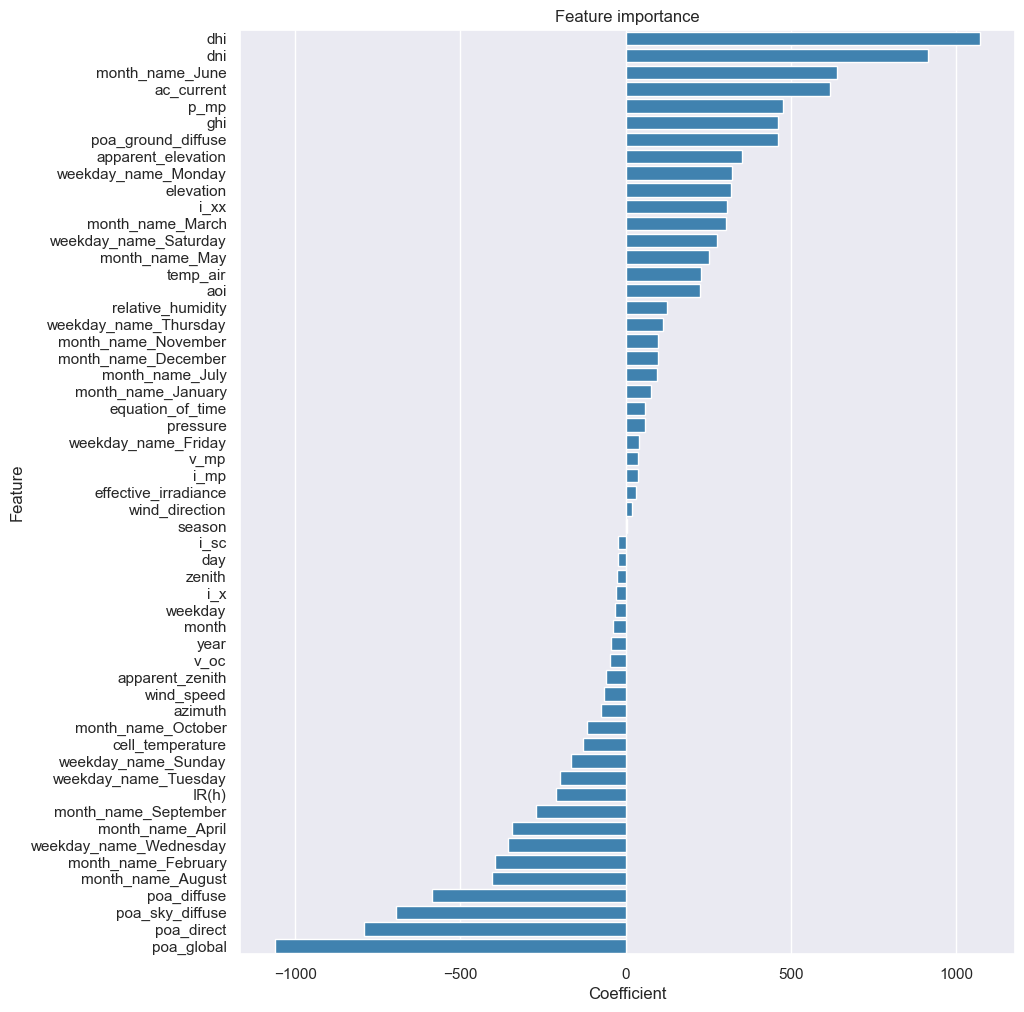

In [88]:
from sklearn.linear_model import RidgeCV
# get formual from logistic regression
# get the best estimator
best_estimator = lm_search.best_estimator_

# get the preprocessor
preprocessor = best_estimator.named_steps["columntransformer"]

# get the one hot encoder
ohe_names = preprocessor.named_transformers_["cat_pipe"].get_feature_names_out()

# get the feature names
feature_names = (
    list(X_num_columns) +
    list(ohe_names)
)

# get the coefficients
coefficients = best_estimator.named_steps["ridgecv"].coef_

# create a dataframe
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# plot the coefficients
plt.figure(figsize=(10, 12))
sns.barplot(x="Coefficient", y="Feature", data=coefficients_df, color="#2E86C1")
plt.title("Feature importance")
plt.show()

The feature distribution makes sense with the reality and the predictors most relevant in the specialized literature are the ones with a higher score on the "Feature Importance" graph

In [96]:
def Pred_graph(Y_search):
    plt.figure(figsize = (16,8))
    counts, bins = np.histogram(Y_search)
    ax = plt.hist(bins[:-1], bins, weights=counts)
    plt.ylabel('Number of Observations')
    plt.xlabel( "Power (Wh)")
    ax = ax
    plt.show
    return ax
    

(array([ 56., 201., 202., 173., 102.,  86.,  85.,  68.,  45.,  13.]),
 array([-2381.78144673,   212.87800703,  2807.5374608 ,  5402.19691457,
         7996.85636834, 10591.5158221 , 13186.17527587, 15780.83472964,
        18375.49418341, 20970.15363717, 23564.81309094]),
 <BarContainer object of 10 artists>)

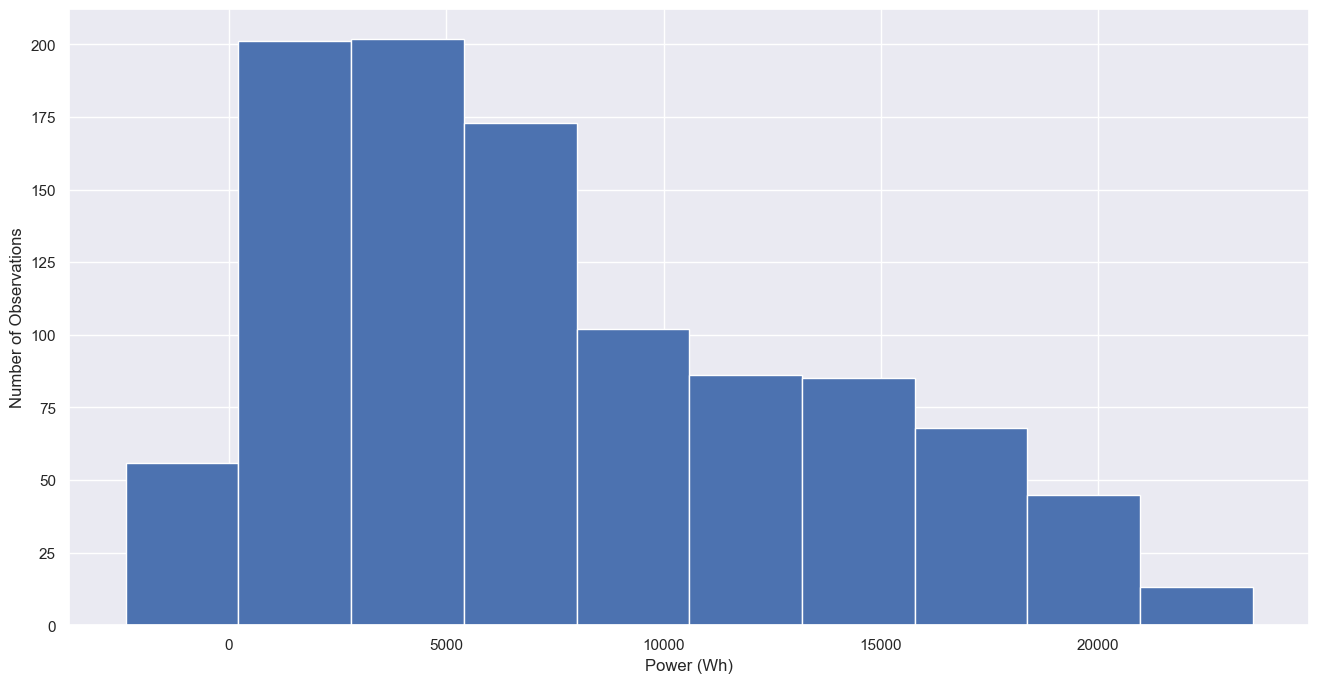

In [97]:
y_predict = lm_search.predict(X_test)
y_predict = pd.DataFrame(data=y_predict)
y_predict.reset_index()
Pred_graph(y_predict)

<AxesSubplot:title={'center':'Predict x Real'}, xlabel='Energy - Predict', ylabel='Energy - Predict - Real'>

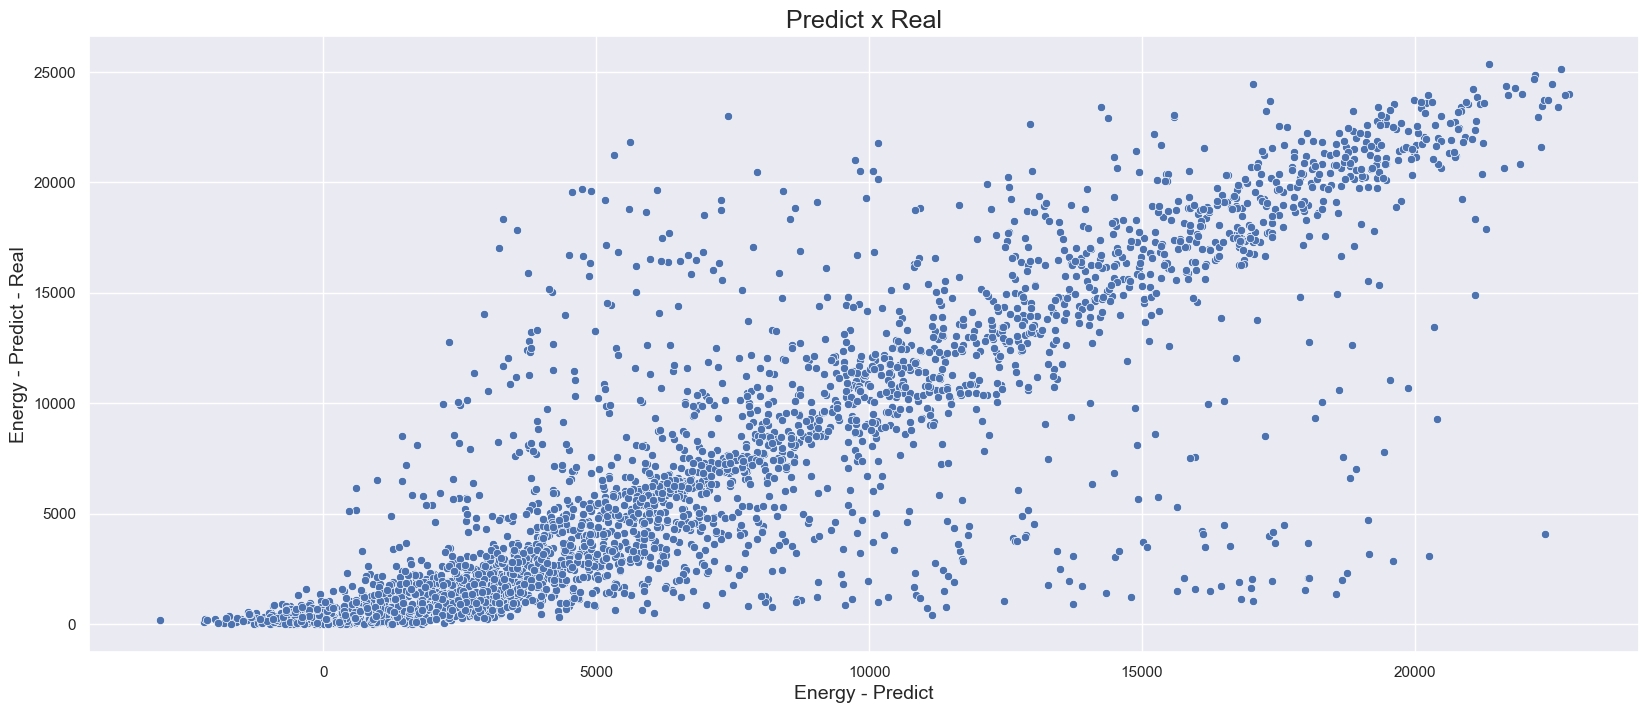

In [98]:
y_train_lm = y_train
y_predict_train_lm = lm_search.predict(X_train)

ax = sns.scatterplot(x=y_predict_train_lm, y=y_train_lm)
ax.figure.set_size_inches(20,8)
ax.set_title("Predict x Real", fontsize=18)
ax.set_xlabel("Energy - Predict", fontsize=14)
ax.set_ylabel("Energy - Predict - Real", fontsize=14)
ax

In [99]:
residue_lm = y_train_lm - y_predict_train_lm
residue_lm

1450    1710.872049
5105     177.344325
1735   -1359.630669
7646    -436.835799
2647    1189.245663
           ...     
3232    -689.180968
5124   -6880.595431
2269     742.288648
2455    -140.587139
398    -1165.371004
Name: Power(Wh), Length: 3092, dtype: float64

<AxesSubplot:title={'center':'Residue x Predict'}, xlabel='Energy - Predict', ylabel='Residue'>

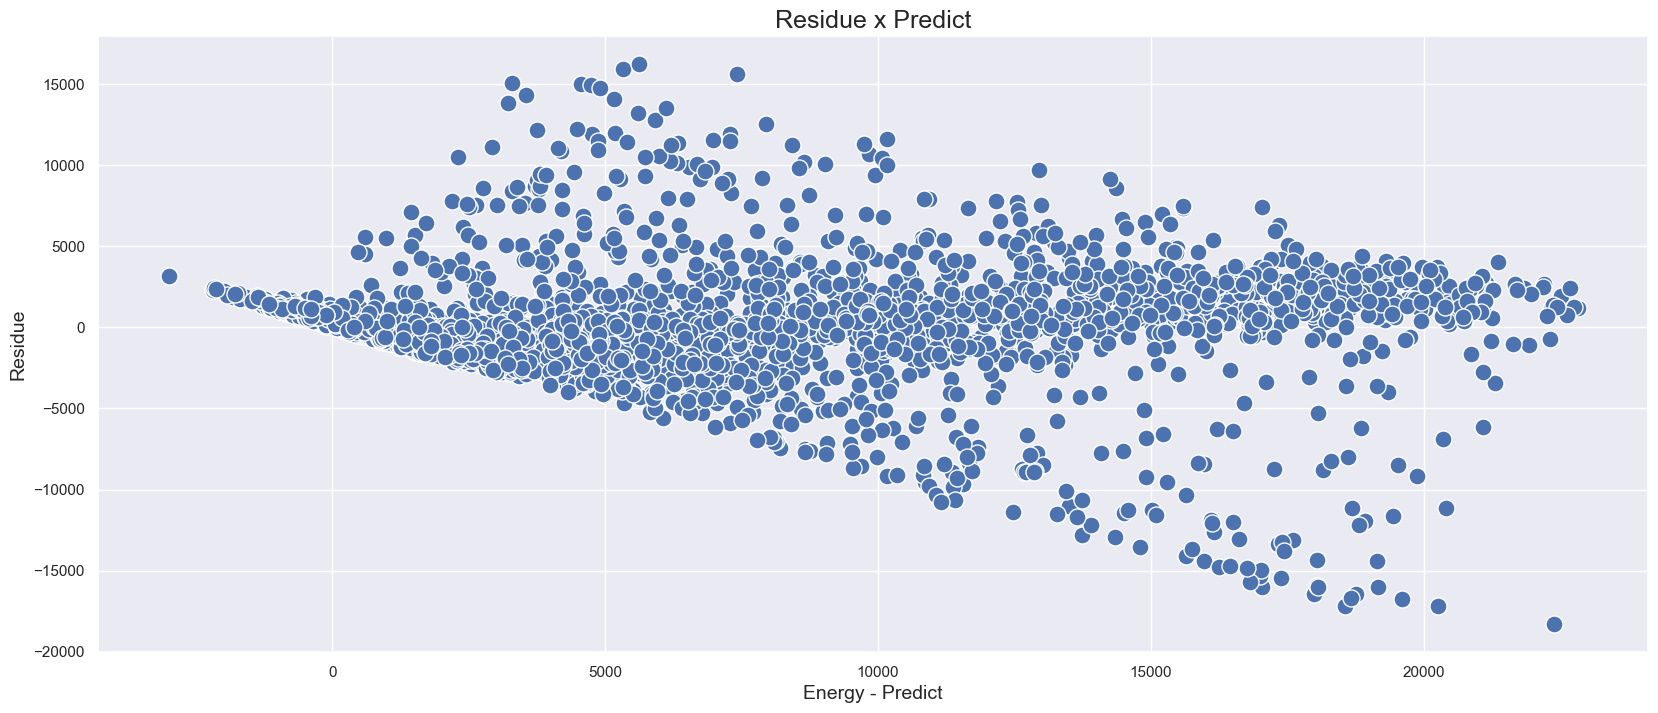

In [100]:
ax = sns.scatterplot(x=y_predict_train_lm, y=residue_lm, s= 150) #o parametro s define o tamanho dos "pontos" do scatterplot
ax.figure.set_size_inches(20,8)
ax.set_title("Residue x Predict", fontsize=18)
ax.set_xlabel("Energy - Predict", fontsize=14)
ax.set_ylabel("Residue", fontsize=14)
ax

<AxesSubplot:title={'center':'Residue x Predict'}, xlabel='Energy - Predict', ylabel='Residue'>

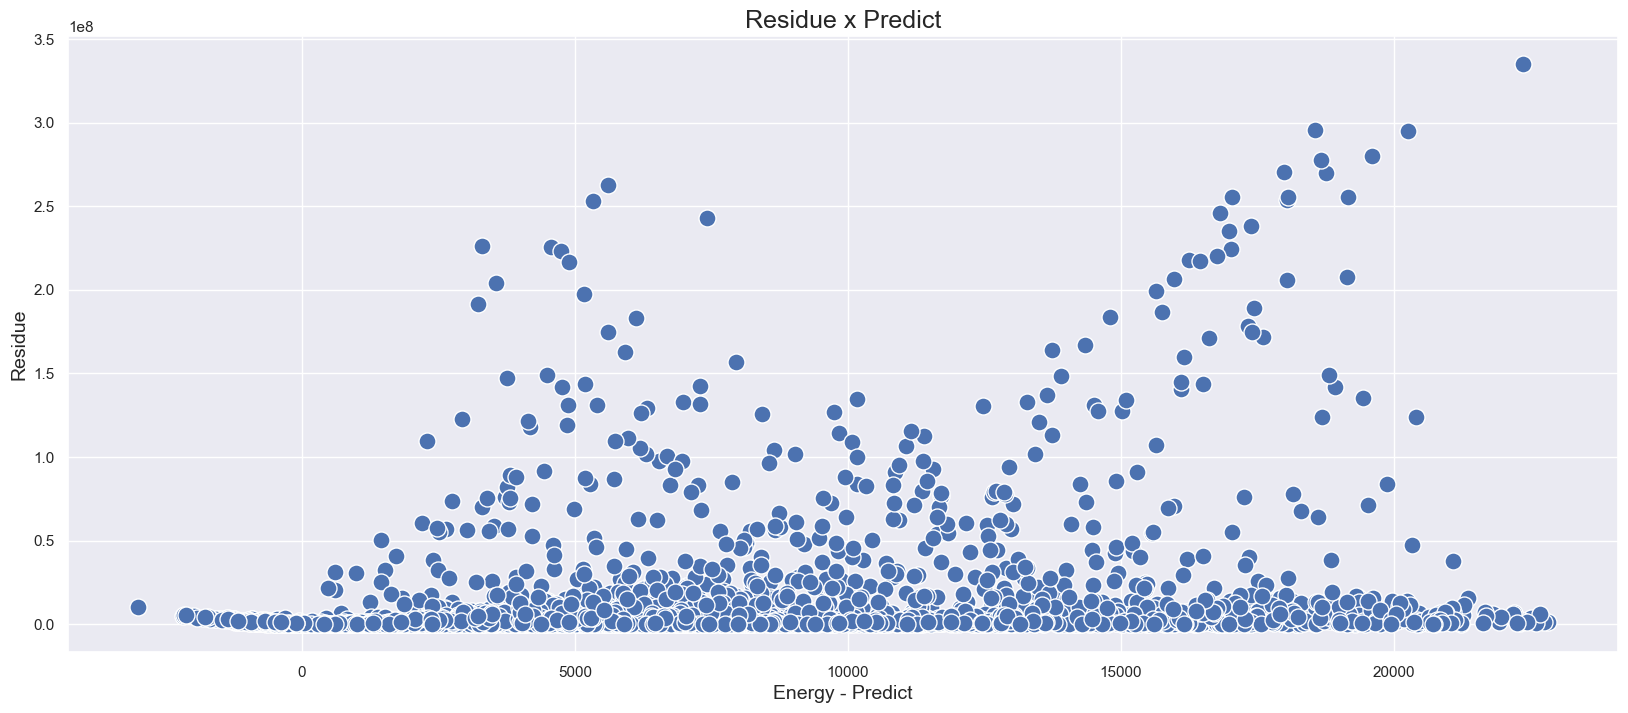

In [102]:
# Using the square value of the residue
ax = sns.scatterplot(x=y_predict_train_lm, y=residue_lm**2, s= 150) 
ax.figure.set_size_inches(20,8)
ax.set_title("Residue x Predict", fontsize=18)
ax.set_xlabel("Energy - Predict", fontsize=14)
ax.set_ylabel("Residue", fontsize=14)
ax

C:\Users\icaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Residue Frequency Distribution'}, xlabel='Energy (Wh)', ylabel='Density'>

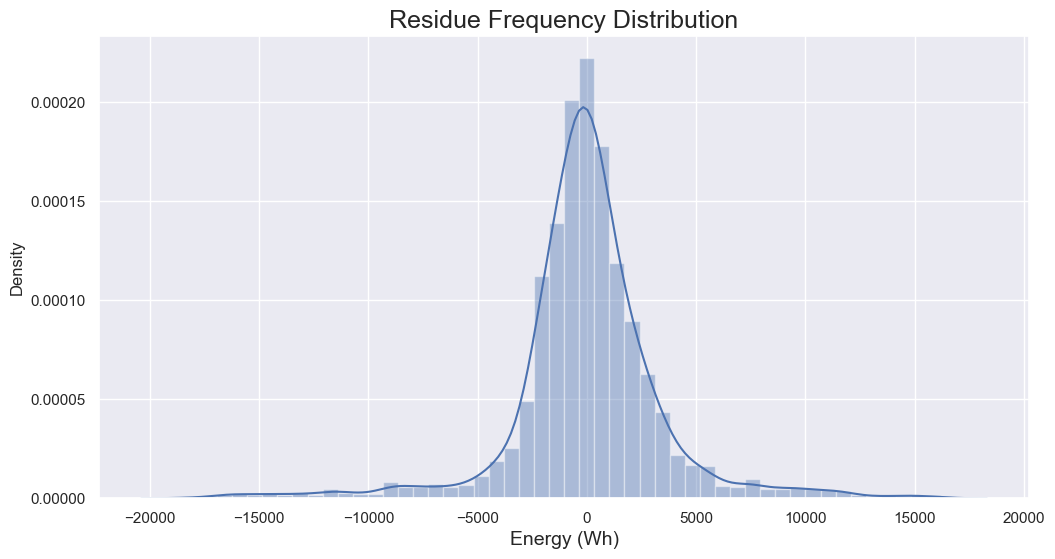

In [103]:
ax = sns.distplot(residue_lm) 
#ax = sns.distplot(residue, bins=50) 
ax.figure.set_size_inches(12,6)
ax.set_title("Residue Frequency Distribution", fontsize=18)
ax.set_xlabel("Energy (Wh)", fontsize=14)
ax

## Using Other Metrics such as MSE, RMSE and R²

In [105]:
y_test_lm = y_test
y_predict_lm = lm_search.predict(X_test)

from sklearn import metrics
MSE = metrics.mean_squared_error(y_test_lm, y_predict_lm).round(4)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_lm, y_predict_lm)).round(4)
R2 = metrics.r2_score(y_test_lm, y_predict_lm).round(4)
                      
pd.DataFrame([MSE, RMSE, R2], ['EQM', 'REQM', 'R²'], columns=['Metrics'])

,Metrics
EQM,1.304376e+07
REQM,3.611614e+03
R²,7.224000e-01


## Tuning the RandomForestRegressor

In [107]:
from sklearn.ensemble import RandomForestRegressor

X_cat_columns = X_train.select_dtypes(include="object").columns
X_num_columns = X_train.select_dtypes(exclude="object").columns

#Setting the imputers, Scaler 
imputer = KNNImputer()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MinMaxScaler(feature_range=(0, 10))
#ang_imputer = KNNImputer()
#ang_scaler = Normalizer()

# create numerical pipeline
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     
# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns)
        
    ]
)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor, 
                              RandomForestRegressor())

param_grid = {
    #"columntransformer__num_pipe__standardscaler__with_mean":[True, False],
    #"columntransformer__num_pipe__standardscaler__with_std":[True, False],
    #"columntransformer__num_pipe__normalizer__with_std":[True, False],
    "columntransformer__cat_pipe__onehotencoder__handle_unknown" : ["ignore"],
    #"randomforestregressor__n_estimators": range(100,500,100),
    "randomforestregressor__criterion": ["squared_error", "absolute_error", "poisson"],
    "randomforestregressor__max_depth": range(2,20,2),
    #"randomforestregressor__min_samples_split" : range(2,10,2),
    #"randomforestregressor__min_samples_leaf" : range(100,1000,200),
    #"randomforestregressor__min_weight_fraction_leaf" : range(1.0,10.0,2.0),
    "randomforestregressor__max_features" : ["sqrt", "log2", 1.0], #auto is deprecated and 1.0 does the same
    "randomforestregressor__max_leaf_nodes": range(10,100,10),
    "randomforestregressor__max_leaf_nodes": range(10,100,10),
    "randomforestregressor__bootstrap": [True,False],    
    
}

rfr_search = RandomizedSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      n_jobs=-1,
                      verbose=1)

print(rfr_search.fit(X_train, y_train))
print("/n")
print(f'model score on training data: {rfr_search.score(X_train, y_train)}')
print(f'model score on testing data: {rfr_search.score(X_test, y_test)}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
print(f'model score on training data: {rfr_search.score(X_train, y_train).round(3)}')
print(f'model score on testing data: {rfr_search.score(X_test, y_test).round(3)}')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# get formual from logistic regression
# get the best estimator
best_estimator = rfr_search.best_estimator_

# get the preprocessor
preprocessor = best_estimator.named_steps["columntransformer"]

# get the one hot encoder
ohe_names = preprocessor.named_transformers_["cat_pipe"].get_feature_names_out()

# get the feature names
feature_names = (
    list(X_num_columns) +
    list(ohe_names)
)

# get the coefficients
coefficients = best_estimator.named_steps["randomforestregressor"].feature_importances_

# create a dataframe
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# plot the coefficients
plt.figure(figsize=(10, 12))
sns.barplot(x="Coefficient", y="Feature", data=coefficients_df, color="#2E86C1")
plt.title("Feature importance")
plt.show()

The RamdomForest regressor has a higher acurracy than the other linear models, but the feature importance graph shows some variables, that were expected to have a high importance, don't contribute significatively to the predictive model. As expected.

In [ ]:
y_predict = rfr_search.predict(X_test)
y_predict = pd.DataFrame(data=y_predict)
y_predict.reset_index()
Pred_graph(y_predict)

# Creating some Graphs to explore the Errors and Residue distribution

In [ ]:
y_train_rfr = y_train
y_predict_train_rfr = rfr_search.predict(X_train)

ax = sns.scatterplot(x=y_predict_train_rfr, y=y_train_rfr)
ax.figure.set_size_inches(20,8)
ax.set_title("Predict x Real", fontsize=18)
ax.set_xlabel("Energy - Predict", fontsize=14)
ax.set_ylabel("Energy - Predict - Real", fontsize=14)
ax

In [ ]:
residue_rfr = y_train_rfr - y_predict_train_rfr
residue_rfr

In [ ]:
ax = sns.scatterplot(x=y_predict_train_rfr, y=residue_rfr, s= 150) #o parametro s define o tamanho dos "pontos" do scatterplot
ax.figure.set_size_inches(20,8)
ax.set_title("Residue x Predict", fontsize=18)
ax.set_xlabel("Energy - Predict", fontsize=14)
ax.set_ylabel("Residue", fontsize=14)
ax

In [ ]:
# Using the square value of the residue
ax = sns.scatterplot(x=y_predict_train_rfr, y=residue_rfr**2, s= 150) #o parametro s define o tamanho dos "pontos" do scatterplot
ax.figure.set_size_inches(20,8)
ax.set_title("Residue x Predict", fontsize=18)
ax.set_xlabel("Energy - Predict", fontsize=14)
ax.set_ylabel("Residue", fontsize=14)
ax

In [ ]:
ax = sns.distplot(residue_rfr) 
#ax = sns.distplot(residue, bins=50) 
ax.figure.set_size_inches(12,6)
ax.set_title("Residue Frequency Distribution", fontsize=18)
ax.set_xlabel("Energy (Wh)", fontsize=14)
ax

## Using Other Metrics such as MSE, RMSE and R²

In [ ]:
y_test_rfr = y_test
y_predict_rfr = rfr_search.predict(X_test)

from sklearn import metrics
MSE = metrics.mean_squared_error(y_test_rfr, y_predict_rfr).round(4)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_rfr, y_predict_rfr)).round(4)
R2 = metrics.r2_score(y_test_rfr, y_predict_rfr).round(4)
                      
pd.DataFrame([EQM, REQM, R2], ['EQM', 'REQM', 'R²'], columns=['Metrics'])

# Exporting the model

In [ ]:
def Pred_graph(Y_search):
    plt.figure(figsize = (16,8))
    counts, bins = np.histogram(Y_search)
    ax = plt.hist(bins[:-1], bins, weights=counts)
    plt.ylabel('Number of Observations')
    plt.xlabel( "Power (Wh)")
    ax = ax
    plt.show
    return ax

In [114]:
test = pd.read_csv("pv_base.csv")

(array([153., 708., 889., 675., 472., 377., 311., 292., 196.,  50.]),
 array([-2997.69951433,  -341.44825381,  2314.80300672,  4971.05426725,
         7627.30552778, 10283.5567883 , 12939.80804883, 15596.05930936,
        18252.31056989, 20908.56183041, 23564.81309094]),
 <BarContainer object of 10 artists>)

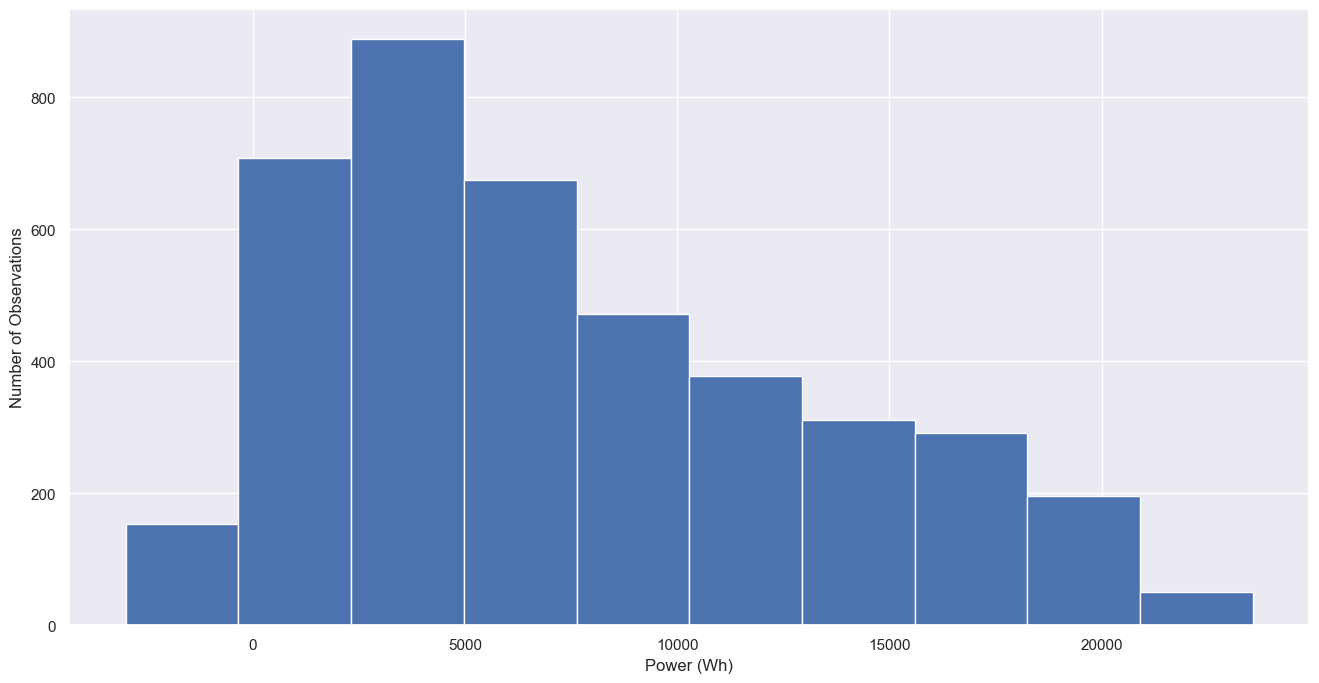

In [116]:
y_predict = lm_search.predict(test)
y_predict = pd.DataFrame(data=y_predict)
y_predict.reset_index()
Pred_graph(y_predict)

In [1]:
import pickle

#Linear Model
output_lm = open('./Pv_linearmodel.sav', "wb")
pickle.dump(lm_search, output_lm)


#RandomForestRegressor Model
#output_rfr = open('./Pv_RamdForReg_model.sav', "wb")
#pickle.dump(rfr_search, output_rfr)

NameError: name 'lm_search' is not defined

In [ ]:
pv_final_cleaned.head()

In [ ]:
pv_final_cleaned.columns

In [ ]:
pv_final_cleaned.to_csv("./pv_final_cleaned.csv",index=False)